In [144]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

tqdm.tqdm.pandas()

In [181]:
# INPUT_FILENAME = "/Volumes/My Passport/ICRA2026-DataCollection/lab446_analysis.parquet" 
# ENV_NAME = "lab446"

INPUT_FILENAME = "/Volumes/My Passport/ICRA2026-DataCollection/fl4_analysis.parquet" 
ENV_NAME = "fl4_kitchenette"

NUM_BINS = 100

In [182]:
df = pd.read_parquet(INPUT_FILENAME)

In [183]:
print(len(df))
df.head()

16653256


,x,y,theta,frameIdx,dist_to_env,k_prime_ratio,frame_0_k_prime,current_k_prime,avg_error,source_file
0,-4.140721,-1.754821,0.250718,100.0,0.176246,1.0,10,10.0,0.0,processed_merged_batch_0775
1,-4.140721,-1.754821,0.250718,200.0,0.176246,1.0,10,10.0,0.0,processed_merged_batch_0775
2,-4.140721,-1.754821,0.250718,300.0,0.176246,1.0,10,10.0,0.0,processed_merged_batch_0775
3,-4.140721,-1.754821,0.250718,400.0,0.176246,1.0,10,10.0,0.0,processed_merged_batch_0775
4,-4.140721,-1.754821,0.250718,500.0,0.176246,1.0,10,10.0,0.0,processed_merged_batch_0775


In [184]:
min_dist_to_env = np.min(df['dist_to_env'])
max_dist_to_env = np.max(df['dist_to_env'])
print(f"Min dist_to_env: {min_dist_to_env:.3f}, max dist_to_env: {max_dist_to_env:.3f}")

Min dist_to_env: 0.000, max dist_to_env: 2.911


In [185]:
bins = np.linspace(min_dist_to_env, max_dist_to_env, NUM_BINS)

In [186]:
def get_bin(value):
    bin_idx = np.digitize([value], bins)[0] - 1
    if bin_idx < 0:
        bin_idx = 0
    elif bin_idx >= NUM_BINS:
        bin_idx = NUM_BINS - 1
    return bin_idx

In [187]:
df["bin"] = df['dist_to_env'].progress_apply(get_bin)
df = df.dropna()

100%|██████████| 16653256/16653256 [00:49<00:00, 334780.13it/s]


In [188]:
df = df.groupby('bin')

In [189]:
stats = df['k_prime_ratio'].agg(['min', 'max', 'sum', 'count', 'mean', 'std', 'var', 'median']).reset_index()

In [190]:
stats['bin_left'] = stats['bin'].apply(lambda x: bins[x])

In [191]:
stats.head()

,bin,min,max,sum,count,mean,std,var,median,bin_left
0,0,0.0,1.0,479636.321007,600033,0.799350,0.173629,0.030147,0.833333,0.000068
1,1,0.0,1.0,718624.556401,900191,0.798302,0.181680,0.033008,0.833333,0.029468
2,2,0.0,1.0,688603.289992,844577,0.815323,0.183897,0.033818,0.866667,0.058867
3,3,0.0,1.0,648394.106401,798388,0.812129,0.178086,0.031715,0.857143,0.088266
4,4,0.0,1.0,613684.920929,761799,0.805573,0.177630,0.031552,0.846154,0.117665


In [192]:
stats_ = stats[stats['bin_left'] < 3.5]

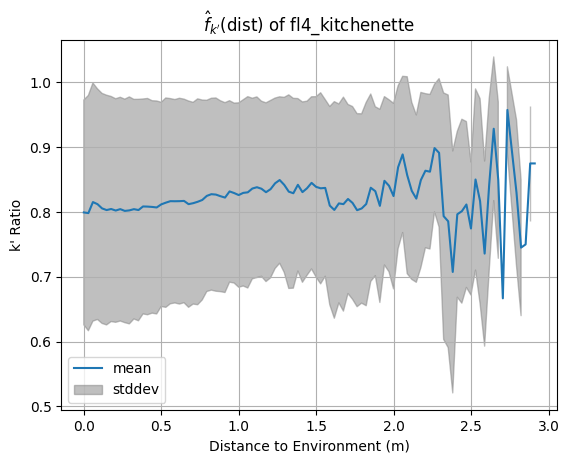

In [193]:
# plt.plot(stats_['bin_left'], stats_['min'], label='min')
# plt.plot(stats_['bin_left'], stats_['max'], label='max')
plt.plot(stats_['bin_left'], stats_['mean'], label='mean')
# plt.plot(stats_['bin_left'], stats_['median'], label='median')
plt.fill_between(stats_['bin_left'], stats_['mean'] - stats_['std'], stats_['mean'] + stats_['std'], color='gray', alpha=0.5, label='stddev')
plt.xlabel('Distance to Environment (m)')
plt.ylabel('k\' Ratio')
plt.title(r"$\hat{f}_{k'}\left(\mathrm{dist}\right)$ of " + ENV_NAME)
plt.legend()
plt.grid()
plt.savefig(f"hat_fkdist_{ENV_NAME}.png", dpi=300)
# plt.show()

In [194]:
simplified_df = stats_[['mean', 'bin_left']]

In [195]:
simplified_df.to_csv(f"hat_fkdist_{ENV_NAME}.csv")

In [196]:
X = simplified_df[["bin_left"]]
y = simplified_df["mean"].values

In [197]:
stump = DecisionTreeRegressor(
    max_depth=1,           # exactly one split
    max_leaf_nodes=2,      # exactly two leaves
    random_state=0
)

In [198]:
stump.fit(X, y)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,2
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [199]:
t = stump.tree_

In [200]:
feature = t.feature[0]
alpha = t.threshold[0]

left = t.children_left[0]
right = t.children_right[0]

y_left = t.value[left][0][0]
y_right = t.value[right][0][0]

In [201]:
print(f"Rule: if x <= {alpha:.6g} then predict {y_left:.6g} else predict {y_right:.6g}")

Rule: if x <= 0.749747 then predict 0.808585 else predict 0.827975
